In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
Jan_2019 = '/content/drive/MyDrive/Flight Delay prediction/Jan_2019_ontime.csv'
Jan_2020 = '/content/drive/MyDrive/Flight Delay prediction/Jan_2020_ontime.csv'

Mounted at /content/drive


In [ ]:
#data load
df1 = pd.read_csv(Jan_2019)
df2 = pd.read_csv(Jan_2020)

In [ ]:
df = pd.concat([df1,df2])

In [ ]:
df.isna().sum()

DAY_OF_MONTH                   0
DAY_OF_WEEK                    0
OP_UNIQUE_CARRIER              0
OP_CARRIER_AIRLINE_ID          0
OP_CARRIER                     0
TAIL_NUM                    3241
OP_CARRIER_FL_NUM              0
ORIGIN_AIRPORT_ID              0
ORIGIN_AIRPORT_SEQ_ID          0
ORIGIN                         0
DEST_AIRPORT_ID                0
DEST_AIRPORT_SEQ_ID            0
DEST                           0
DEP_TIME                   23016
DEP_DEL15                  23054
DEP_TIME_BLK                   0
ARR_TIME                   24136
ARR_DEL15                  26100
CANCELLED                      0
DIVERTED                       0
DISTANCE                       0
Unnamed: 21              1191331
dtype: int64

In [ ]:
df.drop(['Unnamed: 21'], axis=1, inplace = True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().any()

DAY_OF_MONTH             False
DAY_OF_WEEK              False
OP_UNIQUE_CARRIER        False
OP_CARRIER_AIRLINE_ID    False
OP_CARRIER               False
TAIL_NUM                 False
OP_CARRIER_FL_NUM        False
ORIGIN_AIRPORT_ID        False
ORIGIN_AIRPORT_SEQ_ID    False
ORIGIN                   False
DEST_AIRPORT_ID          False
DEST_AIRPORT_SEQ_ID      False
DEST                     False
DEP_TIME                 False
DEP_DEL15                False
DEP_TIME_BLK             False
ARR_TIME                 False
ARR_DEL15                False
CANCELLED                False
DIVERTED                 False
DISTANCE                 False
dtype: bool

In [ ]:
tms_list = list(pd.unique(df['DEP_TIME_BLK']))
df['DEP_TIME_BLK'] = df['DEP_TIME_BLK'].apply(lambda x : tms_list.index(x) + 1)

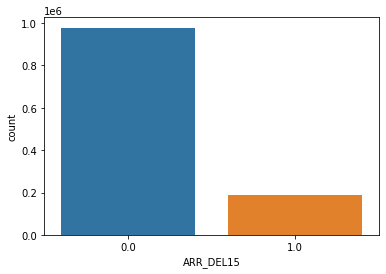

In [ ]:
import seaborn as sns
sns.countplot(x = 'ARR_DEL15', data=df)
#약 5:1(0:1의 비율)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# df['ARR_DEL15'] = df['ARR_DEL15'].astype('category')
# encode_map = {
#     'Delay': 1,
#     'Not Delay': 0
# }
# df['ARR_DEL15'].replace(encode_map, inplace=True)

In [ ]:
X = df.drop(['ARR_DEL15','OP_UNIQUE_CARRIER','CANCELLED','DIVERTED','TAIL_NUM','OP_CARRIER_FL_NUM'
           ,'DEST_AIRPORT_SEQ_ID', 'ORIGIN', 'OP_CARRIER',
          'DEST','ORIGIN_AIRPORT_SEQ_ID'], axis=1)
y = df['ARR_DEL15']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [ ]:
y_train = y_train.to_frame(name='ARR_DEL15')
y_test = y_test.to_frame(name='ARR_DEL15')

In [ ]:
#mean=1, var=0로 스케일링
#그렇게 학습된 scaler의 parameters로 testdata에 transform만 적용
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
## train data
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train),
                       torch.FloatTensor(y_train.values))
## test data
class TestData(Dataset):

    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__ (self):
        return len(self.X_data)


test_data = TestData(torch.FloatTensor(X_test))

In [ ]:
#dataloader = DataLoader(dataset, # 위에서 생성한 데이터 셋,batch_size = 32, # 1회 당 32개의 데이터씩 분할,shuffle = True # 데이터들의 순서는 섞어서 분할)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 10.
        self.layer_1 = nn.Linear(10, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        #64x10 and 12x64
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64) #use the nn.BCEWithLogitsLoss() loss function which automatically applies the the Sigmoid activation!

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = BinaryClassification()
model.to(device)
print(model)

BinaryClassification(
  (layer_1): Linear(in_features=10, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()


    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.23537 | Acc: 92.376
Epoch 002: | Loss: 0.22520 | Acc: 92.493
Epoch 003: | Loss: 0.22341 | Acc: 92.508
Epoch 004: | Loss: 0.22196 | Acc: 92.531
Epoch 005: | Loss: 0.22137 | Acc: 92.537
Epoch 006: | Loss: 0.22073 | Acc: 92.537
Epoch 007: | Loss: 0.22017 | Acc: 92.551
Epoch 008: | Loss: 0.21968 | Acc: 92.557
Epoch 009: | Loss: 0.21947 | Acc: 92.553
Epoch 010: | Loss: 0.21898 | Acc: 92.566
Epoch 011: | Loss: 0.21871 | Acc: 92.574
Epoch 012: | Loss: 0.21826 | Acc: 92.579
Epoch 013: | Loss: 0.21829 | Acc: 92.583
Epoch 014: | Loss: 0.21780 | Acc: 92.590
Epoch 015: | Loss: 0.21728 | Acc: 92.585
Epoch 016: | Loss: 0.21681 | Acc: 92.600
Epoch 017: | Loss: 0.21640 | Acc: 92.596
Epoch 018: | Loss: 0.21574 | Acc: 92.599
Epoch 019: | Loss: 0.21522 | Acc: 92.619
Epoch 020: | Loss: 0.21472 | Acc: 92.605
Epoch 021: | Loss: 0.21426 | Acc: 92.628
Epoch 022: | Loss: 0.21406 | Acc: 92.631
Epoch 023: | Loss: 0.21365 | Acc: 92.637
Epoch 024: | Loss: 0.21378 | Acc: 92.629
Epoch 025: | Los

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[310698,  11763],
       [ 16001,  46065]])

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    322461
         1.0       0.80      0.74      0.77     62066

    accuracy                           0.93    384527
   macro avg       0.87      0.85      0.86    384527
weighted avg       0.93      0.93      0.93    384527

